In [65]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import requests
from datetime import datetime, timedelta
import calendar
import itertools
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
pd.set_option('display.max_columns', 100)
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 발전량 데이터 수집과 전처리

In [150]:
# 발전량 데이터 로드 (출처: Data.go.kr)
power_2020 = pd.read_csv("./한국전력거래소_지역별 5분단위 태양광 계량데이터/지역별_5분_단위_태양광_계량데이터_(2020_01_01 ~ 2020_12_31).csv", encoding="cp949")
power_2021 = pd.read_csv("./한국전력거래소_지역별 5분단위 태양광 계량데이터/지역별_5분_단위_태양광_계량데이터_(2021_01_01 ~ 2021_12_31).csv", encoding="cp949")
power_2022 = pd.read_csv("./한국전력거래소_지역별 5분단위 태양광 계량데이터/지역별_5분_단위_태양광_계량데이터_(2022_01_01 ~ 2022_12_31).csv", encoding="cp949")
power_2023 = pd.read_csv("./한국전력거래소_지역별 5분단위 태양광 계량데이터/지역별_5분_단위_태양광_계량데이터_(2023_01_01 ~ 2023_05_31).csv", encoding="cp949")

In [151]:
# 발전량 데이터 통합
power_data=[]
# 데이터에 올려둔 각 파일을 파일별로 부른다
# 현재까지 저장한 데이터의 갯수를 읽어 seq저장하고 row번호를 계산하는데 이용한다
# 사용할 컬럼만 가져와 저장하고
# 5분단위로 저장되어 있는 값을 합산하여 1시간당 합계 값으로 변환한다.
for data in [power_2020,power_2021,power_2022,power_2023]:
    seq = len(power_data)
    for i in range(data.shape[0]):
        power_data.append(data.iloc[i,1:4])
        power_data[seq+i]["합계"] = data.iloc[i,4:].sum()

In [152]:
# 발전량 데이터 전처리
power_data_df = pd.DataFrame(power_data).reset_index(drop=True)
# 두글자로 지역명 매핑
local_tag_dic = {'강원도': '강원', '경기도': '경기', '경상남도': '경남', '경상북도': '경북', '광주시': '광주', '대구시': '대구', '대전시': '대전', '부산시': '부산', '서울시': '서울', '세종시': '세종', '울산시': '울산', '인천시': '인천', '전라남도': '전남', '전라북도': '전북', '제주도': '제주', '충청남도': '충남', '충청북도': '충북'}
power_data_df['지역'] = power_data_df['지역'].replace(local_tag_dic)
# 날짜와 시간데이터가 들어있는 행을 합쳐서 datetime타입으로 통합
power_data_df['일시'] = pd.to_datetime(power_data_df['거래일']) + pd.to_timedelta(power_data_df['시간'], unit='h')
# 열 다듬기
power_data_df = power_data_df.drop(columns=['거래일','시간'])
power_data_df = power_data_df[['지역','일시','합계']]
power_data_df.columns = ['LOC', 'TM', 'value']

In [76]:
# power_data_df.to_csv('csv_files/imsi_power_data.csv')

# power_data_df = pd.read_csv('csv_files/imsi_power_data.csv', parse_dates=['TM'], index_col=0)

In [77]:
power_data_dic = {
    '강원': power_data_df[power_data_df['LOC']=='강원'].copy().reset_index(drop=True), '경기': power_data_df[power_data_df['LOC']=='경기'].copy().reset_index(drop=True),
    '경남': power_data_df[power_data_df['LOC']=='경남'].copy().reset_index(drop=True), '경북': power_data_df[power_data_df['LOC']=='경북'].copy().reset_index(drop=True),
    '광주': power_data_df[power_data_df['LOC']=='광주'].copy().reset_index(drop=True), '대구': power_data_df[power_data_df['LOC']=='대구'].copy().reset_index(drop=True),
    '대전': power_data_df[power_data_df['LOC']=='대전'].copy().reset_index(drop=True), '부산': power_data_df[power_data_df['LOC']=='부산'].copy().reset_index(drop=True),
    '서울': power_data_df[power_data_df['LOC']=='서울'].copy().reset_index(drop=True), '세종': power_data_df[power_data_df['LOC']=='세종'].copy().reset_index(drop=True),
    '울산': power_data_df[power_data_df['LOC']=='울산'].copy().reset_index(drop=True), '인천': power_data_df[power_data_df['LOC']=='인천'].copy().reset_index(drop=True),
    '전남': power_data_df[power_data_df['LOC']=='전남'].copy().reset_index(drop=True), '전북': power_data_df[power_data_df['LOC']=='전북'].copy().reset_index(drop=True),
    '제주': power_data_df[power_data_df['LOC']=='제주'].copy().reset_index(drop=True), '충남': power_data_df[power_data_df['LOC']=='충남'].copy().reset_index(drop=True),
    '충북': power_data_df[power_data_df['LOC']=='충북'].copy().reset_index(drop=True)
}

In [9]:
# 기상 미래예측을 일단위로 하기 때문에 각 날에 대한 시간별 데이터를 평균으로 통합
date_range = pd.date_range(start=datetime(2020, 1, 1), end=datetime(2023, 5, 31), freq='D')
for local in power_data_dic.keys():
    tmp_df = power_data_dic[local].copy()
    new_df = pd.DataFrame({
        'LOC': local,
        'TM': date_range
    })
    
    for i in range(len(date_range)):
        start_index = i*24
        end_index = (i+1)*24
        new_df.at[i,'value'] = tmp_df.iloc[start_index:end_index,2].sum()
    power_data_dic[local] = new_df.copy()

In [190]:
# 지역별 데이터를 통합
merge_power_data_list = list(power_data_dic.values())
merge_power_data_df = pd.concat(merge_power_data_list, axis=0, ignore_index=True)

In [78]:
# merge_power_data_df.to_csv('csv_files/power_data.csv')

merge_power_data_df = pd.read_csv('csv_files/power_data.csv', parse_dates=['TM'], index_col=0)

In [79]:
power_data_dic = {
    '강원': merge_power_data_df[merge_power_data_df['LOC']=='강원'].copy().reset_index(drop=True),
    '경기': merge_power_data_df[merge_power_data_df['LOC']=='경기'].copy().reset_index(drop=True),
    '경남': merge_power_data_df[merge_power_data_df['LOC']=='경남'].copy().reset_index(drop=True),
    '경북': merge_power_data_df[merge_power_data_df['LOC']=='경북'].copy().reset_index(drop=True),
    '광주': merge_power_data_df[merge_power_data_df['LOC']=='광주'].copy().reset_index(drop=True),
    '대구': merge_power_data_df[merge_power_data_df['LOC']=='대구'].copy().reset_index(drop=True),
    '대전': merge_power_data_df[merge_power_data_df['LOC']=='대전'].copy().reset_index(drop=True),
    '부산': merge_power_data_df[merge_power_data_df['LOC']=='부산'].copy().reset_index(drop=True),
    '서울': merge_power_data_df[merge_power_data_df['LOC']=='서울'].copy().reset_index(drop=True),
    '세종': merge_power_data_df[merge_power_data_df['LOC']=='세종'].copy().reset_index(drop=True),
    '울산': merge_power_data_df[merge_power_data_df['LOC']=='울산'].copy().reset_index(drop=True),
    '인천': merge_power_data_df[merge_power_data_df['LOC']=='인천'].copy().reset_index(drop=True),
    '전남': merge_power_data_df[merge_power_data_df['LOC']=='전남'].copy().reset_index(drop=True),
    '전북': merge_power_data_df[merge_power_data_df['LOC']=='전북'].copy().reset_index(drop=True),
    '제주': merge_power_data_df[merge_power_data_df['LOC']=='제주'].copy().reset_index(drop=True),
    '충남': merge_power_data_df[merge_power_data_df['LOC']=='충남'].copy().reset_index(drop=True),
    '충북': merge_power_data_df[merge_power_data_df['LOC']=='충북'].copy().reset_index(drop=True)
}

## 기상 데이터 수집과 전처리

In [3]:
# 기상 데이터 로드 (기상청 API)
start_date = datetime(2015, 1, 1)
start_date_backup = start_date
end_date = datetime(2023, 12, 31)
key_code = 'xHhvuCsiSD-4b7grIpg_tQ'
weather_data_list = []
columns_num = 46

while start_date<=end_date:
    # 1회 최대 호출 일수가 30일이기 때문에 datetime을 사용하여 기간 설정 
    s_date = start_date
    start_date += timedelta(days=29)
    if start_date>end_date:
        start_date = end_date
    e_date = start_date
    # 데이터를 호출해 리스트로 저장
    url1 = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm3.php?'
    url2 = f'tm1={s_date.year}{s_date.month:02d}{s_date.day:02d}0000&tm2={e_date.year}{e_date.month:02d}{e_date.day:02d}2300&stn=0&help=0&authKey={key_code}'
    month_data = requests.get(url1+url2).text.split()
    # start_dir을 설정해 사용할 데이터가 아닌 열 이름과 단위는 건너뛰고 시작, 종료문자가 나오면 데이터 저장 종료, columns_num은 데이터 호출 시 얻는 데이터의 개수
    start_dir = 93
    while(month_data[start_dir]!='#7777END'):
        line_data = []
        for _ in range(columns_num):
            line_data.append(month_data[start_dir])
            start_dir += 1
        weather_data_list.append(line_data)
    # 다음 기간을 위해 하루 이동
    start_date += timedelta(days=1)
    # 진행도 출력
    clear_output(wait=True)
    print(s_date.strftime('%Y-%m-%d'), '~', e_date.strftime('%Y-%m-%d'), 'Completed')
# 최종 진행도 출력
clear_output(wait=True)
print(start_date_backup.strftime('%Y-%m-%d'), '~', e_date.strftime('%Y-%m-%d'), 'All Completed')

2012-01-01 ~ 2023-12-31 All Completed


In [ ]:
# 기상 데이터 전처리
weather_data_df = pd.DataFrame(weather_data_list, columns=['TM','STN','WD','WS','GST_WD','GST_WS','GST_TM','PA','PS','PT','PR','TA','TD','HM','PV','RN','RN_DAY','RN_JUN','RN_INT','SD_HR3','SD_DAY','SD_TOT','WC','WP','WW','CA_TOT','CA_MID','CH_MIN','CT','CT_TOP','CT_MID','CT_LOW','VS','SS','SI','ST_GD','TS','TE_005','TE_01','TE_02','TE_03','ST_SEA','WH','BF','IR','IX'])

In [16]:
# weather_data_df.to_csv('csv_files/imsi_weather_data.csv')

# weather_data_df = pd.read_csv('csv_files/imsi_weather_data.csv' , index_col=0)

In [92]:
# weather_data_df.to_csv('csv_files/imsi_full_weather_data.csv')

# weather_data_df = pd.read_csv('csv_files/imsi_full_weather_data.csv' , index_col=0)

In [214]:
# 활용하기 어려운 데이터 제외
delete_columns = ['WD','GST_WD','GST_WS','GST_TM','PS','PT','PR','RN','RN_DAY','RN_JUN','RN_INT','SD_HR3','SD_DAY','SD_TOT','WC','WP','WW','CT','CT_TOP','CT_MID','CT_LOW','ST_GD','TE_005','TE_01','TE_02','TE_03','ST_SEA','WH','BF','IR','IX']
weather_data_df = weather_data_df.drop(delete_columns, axis=1)

In [215]:
# 관측소 매핑
local_data_dic = {'강원': [90, 93, 95, 100, 101, 104, 105, 106, 114, 121, 211, 212, 216, 217], '경기': [98, 99, 119, 202, 203], '경남': [155, 162, 192, 253, 255, 257, 263, 264, 284, 285, 288, 289, 294, 295], '경북': [115, 130, 136, 137, 138, 271, 272, 273, 276, 277, 278, 279, 281, 283], '광주': [156], '대구': [143], '대전': [133], '부산': [159, 296], '서울': [108], '세종': [239], '울산': [152], '인천': [102, 112, 201], '전남': [165, 168, 169, 170, 174, 252, 258, 259, 260, 261, 262, 266, 268], '전북': [140, 146, 172, 243, 244, 245, 247, 248, 251, 254], '제주': [184, 185, 188, 189], '충남': [129, 177, 232, 235, 236, 238], '충북': [127, 131, 135, 181, 221, 226]}
# nan으로 채운 새로운 행을 맨 앞에 삽입후 str타입으로 변경 + 데이터 타입 일괄 변경
weather_data_df.insert(0, 'LOC', np.nan)
weather_data_df['LOC'] = weather_data_df['LOC'].astype(str)
weather_data_df['TM'] = pd.to_datetime(weather_data_df['TM'], format='%Y%m%d%H%M')
weather_data_df['STN'] = weather_data_df['STN'].astype(int)
weather_data_df['WS'] = weather_data_df['WS'].astype(float).round(1)
weather_data_df['PA'] = weather_data_df['PA'].astype(float).round(1)
weather_data_df['TA'] = weather_data_df['TA'].astype(float).round(1)
weather_data_df['TD'] = weather_data_df['TD'].astype(float).round(1)
weather_data_df['HM'] = weather_data_df['HM'].astype(float).round(1)
weather_data_df['PV'] = weather_data_df['PV'].astype(float).round(1)
weather_data_df['CA_TOT'] = weather_data_df['CA_TOT'].astype(int)
weather_data_df['CA_MID'] = weather_data_df['CA_MID'].astype(int)
weather_data_df['CH_MIN'] = weather_data_df['CH_MIN'].astype(int)
weather_data_df['VS'] = weather_data_df['VS'].astype(int)
weather_data_df['SS'] = weather_data_df['SS'].astype(float).round(1)
weather_data_df['SI'] = weather_data_df['SI'].astype(float).round(2)
weather_data_df['TS'] = weather_data_df['TS'].astype(float).round(1)
# weather_data_df의 STN(관측소번호)을 순회하면서 해당 번호가 local_data_dic의 value안에 있으면 value의 key를 LOC에 입력
for idx, stn_value in enumerate(weather_data_df['STN']):
    for loc, stn_list in local_data_dic.items():
        if stn_value in stn_list:
            weather_data_df.at[idx, 'LOC'] = loc
            break

In [216]:
# 지역별로 따로 관리하기 위한 딕셔너리 생성
weather_data_dic = {
    '강원': weather_data_df[weather_data_df['LOC']=='강원'].copy().reset_index(drop=True), '경기': weather_data_df[weather_data_df['LOC']=='경기'].copy().reset_index(drop=True),
    '경남': weather_data_df[weather_data_df['LOC']=='경남'].copy().reset_index(drop=True), '경북': weather_data_df[weather_data_df['LOC']=='경북'].copy().reset_index(drop=True),
    '광주': weather_data_df[weather_data_df['LOC']=='광주'].copy().reset_index(drop=True), '대구': weather_data_df[weather_data_df['LOC']=='대구'].copy().reset_index(drop=True),
    '대전': weather_data_df[weather_data_df['LOC']=='대전'].copy().reset_index(drop=True), '부산': weather_data_df[weather_data_df['LOC']=='부산'].copy().reset_index(drop=True),
    '서울': weather_data_df[weather_data_df['LOC']=='서울'].copy().reset_index(drop=True), '세종': weather_data_df[weather_data_df['LOC']=='세종'].copy().reset_index(drop=True),
    '울산': weather_data_df[weather_data_df['LOC']=='울산'].copy().reset_index(drop=True), '인천': weather_data_df[weather_data_df['LOC']=='인천'].copy().reset_index(drop=True),
    '전남': weather_data_df[weather_data_df['LOC']=='전남'].copy().reset_index(drop=True), '전북': weather_data_df[weather_data_df['LOC']=='전북'].copy().reset_index(drop=True),
    '제주': weather_data_df[weather_data_df['LOC']=='제주'].copy().reset_index(drop=True), '충남': weather_data_df[weather_data_df['LOC']=='충남'].copy().reset_index(drop=True),
    '충북': weather_data_df[weather_data_df['LOC']=='충북'].copy().reset_index(drop=True)
}

In [217]:
# WS: 풍속 (m/s), PA: 현지기압 (hPa), TA: 기온 (C), TD: 이슬점온도 (C), HM: 상대습도 (%), PV: 수증기압 (hPa), CA_TOT: 전운량 (1/10), CA_MID: 중하층운량 (1/10), CH_MIN: 최저운고 (100m), VS: 시정 (10m), SS: 일조 (hr), SI: 일사 (MJ/m2), TS: 지면온도 (C)
for local_name, local_df in weather_data_dic.items():
    tmp_df = local_df.copy()
    ws_mean = np.mean(tmp_df.loc[tmp_df['WS']!=-9.0, 'WS']).round(1)
    tmp_df['WS'] = tmp_df['WS'].replace(-9.0, ws_mean)
    pa_mean = np.mean(tmp_df.loc[tmp_df['PA']!=-9.0, 'PA']).round(1)
    tmp_df['PA'] = tmp_df['PA'].replace(-9.0, pa_mean)
    ta_mean = np.mean(tmp_df.loc[tmp_df['TA']!=-99.0, 'TA']).round(1)
    tmp_df['TA'] = tmp_df['TA'].replace(-99.0, ta_mean)
    td_mean = np.mean(tmp_df.loc[tmp_df['TD']!=-99.0, 'TD']).round(1)
    tmp_df['TD'] = tmp_df['TD'].replace(-99.0, td_mean)
    hm_mean = np.mean(tmp_df.loc[tmp_df['HM']!=-9.0, 'HM']).round(1)
    tmp_df['HM'] = tmp_df['HM'].replace(-9.0, hm_mean)
    pv_mean = np.mean(tmp_df.loc[tmp_df['PV']!=-9.0, 'PV']).round(1)
    tmp_df['PV'] = tmp_df['PV'].replace(-9.0, pv_mean)
    tmp_df['CA_TOT'] = tmp_df['CA_TOT'].replace(-9, 0)
    tmp_df['CA_MID'] = tmp_df['CA_MID'].replace(-9, 0)
    tmp_df['CH_MIN'] = tmp_df['CH_MIN'].replace(-9, 0)
    vs_mean = np.mean(tmp_df.loc[tmp_df['VS']!=-9, 'VS']).astype(int)
    tmp_df['VS'] = tmp_df['VS'].replace(-9, vs_mean)
    tmp_df['SS'] = tmp_df['SS'].replace(-9.0, 0.0)
    tmp_df['SI'] = tmp_df['SI'].replace(-9.00, 0.00)
    weather_data_dic[local_name] = tmp_df.copy()

In [218]:
# 도시별로 시간대가 빈 부분에서 TM을 채우고 나머지는 nan으로 입력, 온전한 데이터는 시간대를 기준으로 관측소들의 평균을 냄
date_range = pd.date_range(start=start_date_backup, end=end_date+timedelta(hours=23), freq='H')
for local_name, local_df in weather_data_dic.items():
    tmp_df = local_df.copy()
    new_df = pd.DataFrame({
        'LOC': local_name,
        'TM': date_range
    })
    mean_df = pd.DataFrame({
        'WS': tmp_df.groupby('TM')['WS'].mean().round(1),
        'PA': tmp_df.groupby('TM')['PA'].mean().round(1),
        'TA': tmp_df.groupby('TM')['TA'].mean().round(1),
        'TD': tmp_df.groupby('TM')['TD'].mean().round(1),
        'HM': tmp_df.groupby('TM')['HM'].mean().round(1),
        'PV': tmp_df.groupby('TM')['PV'].mean().round(1),
        'CA_TOT': tmp_df.groupby('TM')['CA_TOT'].mean().astype(int),
        'CA_MID': tmp_df.groupby('TM')['CA_MID'].mean().astype(int),
        'CH_MIN': tmp_df.groupby('TM')['CH_MIN'].mean().astype(int),
        'VS': tmp_df.groupby('TM')['VS'].mean().astype(int),
        'SS': tmp_df.groupby('TM')['SS'].mean().round(1),
        'SI': tmp_df.groupby('TM')['SI'].mean().round(2),
        'TS': tmp_df.groupby('TM')['TS'].mean().round(1)
    }).reset_index()
    merge_df = pd.merge(new_df, mean_df, on='TM', how='left')  
    weather_data_dic[local_name] = merge_df.copy()

In [219]:
# 각 지역의 데이터프레임 중 nan이 포함된 행을 찾아 위쪽의 데이터로 채움
for local in weather_data_dic.keys():
    tmp_df = weather_data_dic[local].copy()
    
    if not tmp_df[tmp_df.isna().any(axis=1)].empty:
        tmp_df.iloc[:,2:] = tmp_df.iloc[:,2:].ffill()
        weather_data_dic[local] = tmp_df.copy()
        print(f'{local}데이터 채움 완료')

경기데이터 채움 완료
광주데이터 채움 완료
대전데이터 채움 완료
부산데이터 채움 완료
세종데이터 채움 완료


In [220]:
# 기상 미래예측을 일단위로 하기 때문에 각 날에 대한 시간별 데이터를 평균으로 통합
date_range = pd.date_range(start=start_date_backup, end=end_date, freq='D')
for local in weather_data_dic.keys():
    if (start_date_backup>datetime(2019,5,31)) or (local!='세종'):
        tmp_df = weather_data_dic[local].copy()
        new_df = pd.DataFrame({
            'LOC': local,
            'TM': date_range
        })

        for i in range(len(date_range)):
            start_index = i*24
            end_index = (i+1)*24
            new_df.at[i,'WS'] = tmp_df.iloc[start_index:end_index,2].mean().round(1)
            new_df.at[i,'PA'] = tmp_df.iloc[start_index:end_index,3].mean().round(1)
            new_df.at[i,'TA'] = tmp_df.iloc[start_index:end_index,4].mean().round(1)
            new_df.at[i,'TD'] = tmp_df.iloc[start_index:end_index,5].mean().round(1)
            new_df.at[i,'HM'] = tmp_df.iloc[start_index:end_index,6].mean().round(1)
            new_df.at[i,'PV'] = tmp_df.iloc[start_index:end_index,7].mean().round(1)
            new_df.at[i,'CA_TOT'] = tmp_df.iloc[start_index:end_index,8].mean().astype(int)
            new_df.at[i,'CA_MID'] = tmp_df.iloc[start_index:end_index,9].mean().astype(int)
            new_df.at[i,'CH_MIN'] = tmp_df.iloc[start_index:end_index,10].mean().astype(int)
            new_df.at[i,'VS'] = tmp_df.iloc[start_index:end_index,11].mean().astype(int)
            new_df.at[i,'SS'] = tmp_df.iloc[start_index:end_index,12].mean().round(1)
            new_df.at[i,'SI'] = tmp_df.iloc[start_index:end_index,13].mean().round(2)
            new_df.at[i,'TS'] = tmp_df.iloc[start_index:end_index,14].mean().round(1)
        weather_data_dic[local] = new_df.copy()

In [ ]:
# 세종시의 데이터는 2019년 6월 1일부터 온전한 데이터를 가지고 있음
if start_date_backup<datetime(2019,5,31):
    # 2019.6.1 이전의 데이터는 충남의 데이터를 사용
    sg_nan_date_range = pd.date_range(start=start_date_backup, end=datetime(2019,5,31), freq='D')
    cn_weather_data_df = weather_data_dic['충남'].copy()
    cn_weather_data_df = cn_weather_data_df[(cn_weather_data_df['TM']>=sg_nan_date_range[0]) & (cn_weather_data_df['TM']<=sg_nan_date_range[-1])]
    cn_weather_data_df.loc[:,'LOC'] = '세종'
    # 2019.6.1 부터 세종의 데이터를 사용
    sg_date_range = pd.date_range(start=sg_nan_date_range[-1]+timedelta(days=1), end=end_date)
    tmp_df = weather_data_dic['세종'].copy()
    tmp_df = tmp_df.drop(tmp_df[(tmp_df['TM']>=sg_nan_date_range[0]) & (tmp_df['TM']<=(sg_nan_date_range[-1]+timedelta(days=1)-timedelta(hours=1)))].index).reset_index(drop=True)
    new_df = pd.DataFrame({
            'LOC': '세종',
            'TM': sg_date_range
        })
    
    for i in range(len(sg_date_range)):
        start_index = i*24
        end_index = (i+1)*24
        new_df.at[i,'WS'] = tmp_df.iloc[start_index:end_index,2].mean().round(1)
        new_df.at[i,'PA'] = tmp_df.iloc[start_index:end_index,3].mean().round(1)
        new_df.at[i,'TA'] = tmp_df.iloc[start_index:end_index,4].mean().round(1)
        new_df.at[i,'TD'] = tmp_df.iloc[start_index:end_index,5].mean().round(1)
        new_df.at[i,'HM'] = tmp_df.iloc[start_index:end_index,6].mean().round(1)
        new_df.at[i,'PV'] = tmp_df.iloc[start_index:end_index,7].mean().round(1)
        new_df.at[i,'CA_TOT'] = tmp_df.iloc[start_index:end_index,8].mean().astype(int)
        new_df.at[i,'CA_MID'] = tmp_df.iloc[start_index:end_index,9].mean().astype(int)
        new_df.at[i,'CH_MIN'] = tmp_df.iloc[start_index:end_index,10].mean().astype(int)
        new_df.at[i,'VS'] = tmp_df.iloc[start_index:end_index,11].mean().astype(int)
        new_df.at[i,'SS'] = tmp_df.iloc[start_index:end_index,12].mean().round(1)
        new_df.at[i,'SI'] = tmp_df.iloc[start_index:end_index,13].mean().round(2)
        new_df.at[i,'TS'] = tmp_df.iloc[start_index:end_index,14].mean().round(1)
    new_df = pd.concat([cn_weather_data_df,new_df])
    weather_data_dic['세종'] = new_df.copy()

In [221]:
# 지역별 데이터를 통합
merge_weather_data_list = list(weather_data_dic.values())
merge_weather_data_df = pd.concat(merge_weather_data_list, axis=0, ignore_index=True)

In [72]:
# merge_weather_data_df.to_csv('csv_files/weather_data.csv')

merge_weather_data_df = pd.read_csv('csv_files/weather_data.csv', parse_dates=['TM'], index_col=0)

In [73]:
# merge_weather_data_df.to_csv('csv_files/full_weather_data.csv')

# merge_weather_data_df = pd.read_csv('csv_files/full_weather_data.csv', parse_dates=['TM'], index_col=0)

In [74]:
# 지역별로 따로 관리하기 위한 딕셔너리 생성
weather_data_dic = {
    '강원': merge_weather_data_df[merge_weather_data_df['LOC']=='강원'].copy().reset_index(drop=True),
    '경기': merge_weather_data_df[merge_weather_data_df['LOC']=='경기'].copy().reset_index(drop=True),
    '경남': merge_weather_data_df[merge_weather_data_df['LOC']=='경남'].copy().reset_index(drop=True),
    '경북': merge_weather_data_df[merge_weather_data_df['LOC']=='경북'].copy().reset_index(drop=True),
    '광주': merge_weather_data_df[merge_weather_data_df['LOC']=='광주'].copy().reset_index(drop=True),
    '대구': merge_weather_data_df[merge_weather_data_df['LOC']=='대구'].copy().reset_index(drop=True),
    '대전': merge_weather_data_df[merge_weather_data_df['LOC']=='대전'].copy().reset_index(drop=True),
    '부산': merge_weather_data_df[merge_weather_data_df['LOC']=='부산'].copy().reset_index(drop=True),
    '서울': merge_weather_data_df[merge_weather_data_df['LOC']=='서울'].copy().reset_index(drop=True),
    '세종': merge_weather_data_df[merge_weather_data_df['LOC']=='세종'].copy().reset_index(drop=True),
    '울산': merge_weather_data_df[merge_weather_data_df['LOC']=='울산'].copy().reset_index(drop=True),
    '인천': merge_weather_data_df[merge_weather_data_df['LOC']=='인천'].copy().reset_index(drop=True),
    '전남': merge_weather_data_df[merge_weather_data_df['LOC']=='전남'].copy().reset_index(drop=True),
    '전북': merge_weather_data_df[merge_weather_data_df['LOC']=='전북'].copy().reset_index(drop=True),
    '제주': merge_weather_data_df[merge_weather_data_df['LOC']=='제주'].copy().reset_index(drop=True),
    '충남': merge_weather_data_df[merge_weather_data_df['LOC']=='충남'].copy().reset_index(drop=True),
    '충북': merge_weather_data_df[merge_weather_data_df['LOC']=='충북'].copy().reset_index(drop=True)
}

## 태양광 발전량 예측

### 앙상블 (Ensemble)
여러 개별 모델을 결합하여 더 강력하고 안정적인 모델을 구축하는 기법

1. 성능 향상: 여러 모델을 결합함으로써 단일 모델보다 높은 예측 성능을 얻을 수 있음
2. 안정성 향상: 다양한 모델을 결합하여 예측의 안정성을 향상
3. 과적합 감소: 다수의 모델을 평균화함으로써 과적합을 감소

- #### 베깅 (Bagging)
    - 과적합 감소, 안정성 향상, 병렬 학습 가능
    - 성능 저하, 해석력 감소
- #### 부스팅 (Boosting)
    - 높은 예측 성능, 오분류에 대한 보상
    - 과적합 가능성, 병렬 학습의 어려움
- #### $R^2$
    - 회귀 모델의 성능을 나타내는 지표
    - 모델이 종속 변수의 변동을 얼마나 잘 설명하는지 측정 (0 ~ 1)

In [122]:
# 강원도의 데이터로 어느 모델이 적합할지 테스트
data = weather_data_dic['강원'].iloc[:,2:].to_numpy()
target = power_data_dic['강원'].iloc[:,2].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

**랜덤 포레스트 훈련기록**

- 1회차  
rf_n_estimators_list = [100, 200, 300, 400, 500]  
rf_min_samples_split_list = [2, 3, 4, 5]  
rf_min_samples_leaf_list = [1, 2, 3]  
*best_params: (400, 4, 1)*  
*test set score: 0.7857550912641822*

- 2회차  
rf_n_estimators_list = [350, 400, 450]  
rf_min_samples_split_list = [3, 4, 5]  
rf_min_samples_leaf_list = [1, 2]  
*best_params: (450, 4, 1)*  
*test set score: 0.7859774605859502*

In [125]:
rf_n_estimators_list = [350, 400, 450]
rf_min_samples_split_list = [3, 4, 5]
rf_min_samples_leaf_list = [1, 2]
rf_params_list = list(itertools.product(rf_n_estimators_list, rf_min_samples_split_list, rf_min_samples_leaf_list))
rf_score_list = []

for idx,coef in enumerate(rf_params_list):
    # Random Forest 훈련
    rf_model = RandomForestRegressor(n_estimators=coef[0], min_samples_split=coef[1], min_samples_leaf=coef[2], n_jobs=-1, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_score_list.append(rf_model.score(X_test, y_test))
    # 진행도 출력
    clear_output(wait=True)
    print(f'진행도: {(idx+1)/len(rf_params_list)*100:.2f}%')

# 최적 파라미터 도출
rf_best_params_idx = rf_score_list.index(max(rf_score_list))
rf_best_params = rf_params_list[rf_best_params_idx]
print(f'best_params: {rf_best_params}')
# 최적 파라미터로 score확인
rf_model = RandomForestRegressor(n_estimators=rf_best_params[0], min_samples_split=rf_best_params[1], min_samples_leaf=rf_best_params[2], n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
print(f'test set score: {rf_model.score(X_test, y_test)}')

진행도: 100.00%
best_params: (450, 4, 1)
test set score: 0.7859774605859502


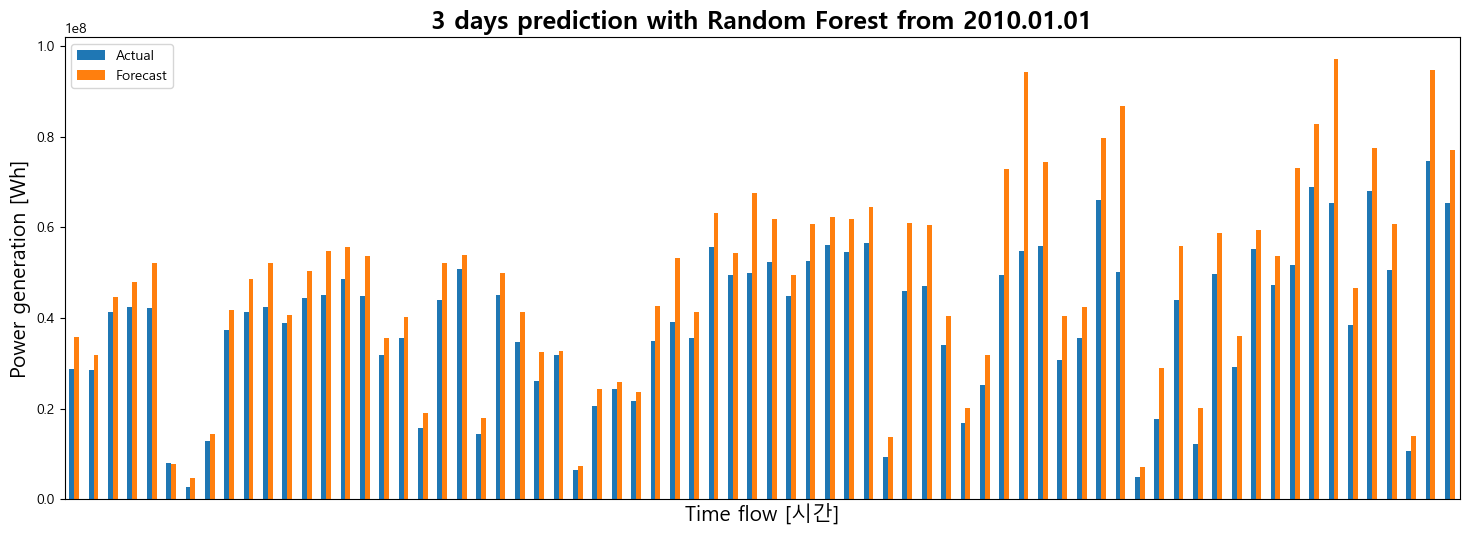

In [126]:
# Random Forest 예측 시각화
days = 3
show_df = pd.DataFrame({
    'hours': power_data_dic['강원'].iloc[:24*days,1],
    'Actual': power_data_dic['강원'].iloc[:24*days,2],
    'Forecast': rf_model.predict(weather_data_dic['강원'].iloc[:24*days,2:].to_numpy())
})

show_df.plot(x='hours', y=['Actual','Forecast'], kind='bar', figsize=(6*days,6))
plt.title(f'{days} days prediction with Random Forest from 2010.01.01', fontsize=18, fontweight='bold')
plt.xlabel('Time flow [시간]', fontsize=15)
plt.ylabel('Power generation [Wh]', fontsize=15)
plt.xticks([])
plt.show()

**그레이디언트 부스팅 훈련기록**

- 1회차  
gb_n_estimators_list = [100, 200, 300, 400]  
gb_learning_rate_list = [0.05, 0.1, 0.2]  
gb_min_samples_split_list = [2, 3, 4]  
gb_min_samples_leaf_list = [1, 2, 3]  
*best_params: (200, 0.1, 4, 1)*  
*test set score: 0.7934066026365478*

- 2회차  
gb_n_estimators_list = [150, 200, 250]  
gb_learning_rate_list = [0.05, 0.1, 0.2]  
gb_min_samples_split_list = [3, 4, 5]  
gb_min_samples_leaf_list = [1, 2]  
*best_params: (150, 0.2, 5, 1)*  
*test set score: 0.7965595488698582*

In [132]:
gb_n_estimators_list = [150, 200, 250]
gb_learning_rate_list = [0.05, 0.1, 0.2]
gb_min_samples_split_list = [3, 4, 5]
gb_min_samples_leaf_list = [1, 2]
gb_params_list = list(itertools.product(gb_n_estimators_list, gb_learning_rate_list, gb_min_samples_split_list, gb_min_samples_leaf_list))
gb_score_list = []

for idx,coef in enumerate(gb_params_list):
    # Gradient Boosting 훈련
    gb_model = GradientBoostingRegressor(n_estimators=coef[0], learning_rate=coef[1], min_samples_split=coef[2], min_samples_leaf=coef[3], random_state=42)
    gb_model.fit(X_train, y_train)
    gb_score_list.append(gb_model.score(X_test, y_test))
    # 진행도 출력
    clear_output(wait=True)
    print(f'진행도: {(idx+1)/len(gb_params_list)*100:.2f}%')

# 최적 파라미터 도출
gb_best_params_idx = gb_score_list.index(max(gb_score_list))
gb_best_params = gb_params_list[gb_best_params_idx]
print(f'best_params: {gb_best_params}')
# 최적 파라미터로 score확인
gb_model = GradientBoostingRegressor(n_estimators=gb_best_params[0], learning_rate=gb_best_params[1], min_samples_split=gb_best_params[2], min_samples_leaf=gb_best_params[3], random_state=42)
gb_model.fit(X_train, y_train)
print(f'test set score: {gb_model.score(X_test, y_test)}')

진행도: 100.00%
best_params: (150, 0.2, 5, 1)
test set score: 0.7965595488698582


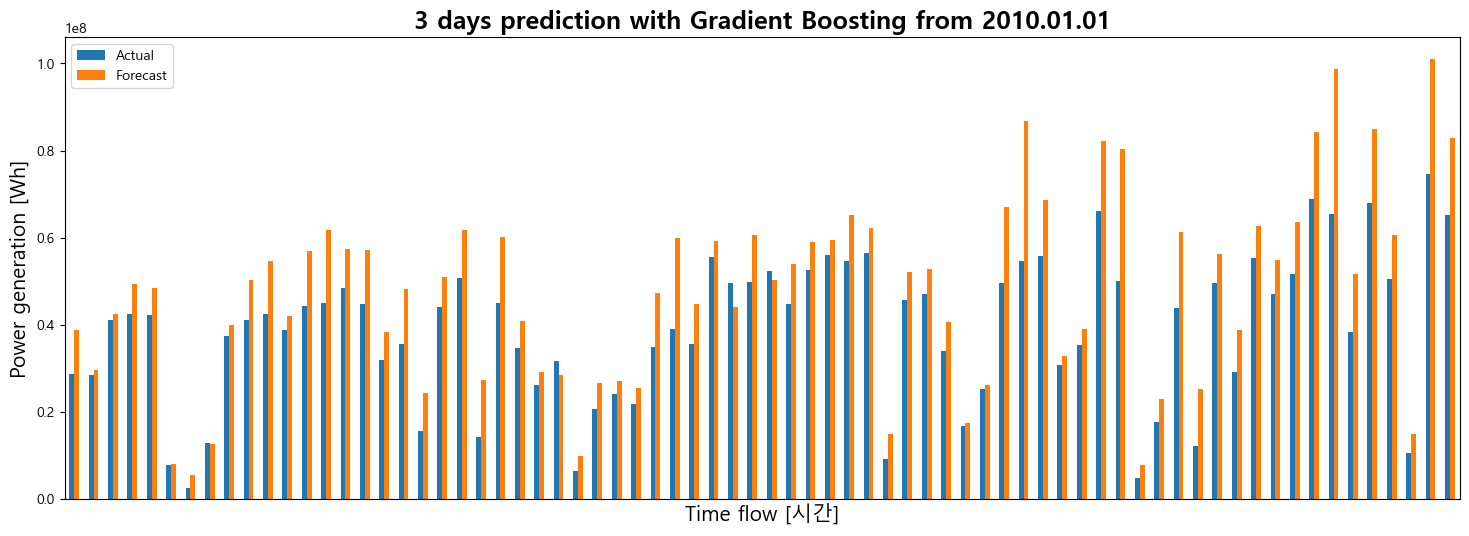

In [133]:
# Gradient Boosting 예측 시각화
days = 3
show_df = pd.DataFrame({
    'hours': power_data_dic['강원'].iloc[:24*days,1],
    'Actual': power_data_dic['강원'].iloc[:24*days,2],
    'Forecast': gb_model.predict(weather_data_dic['강원'].iloc[:24*days,2:].to_numpy())
})

show_df.plot(x='hours', y=['Actual','Forecast'], kind='bar', figsize=(6*days,6))
plt.title(f'{days} days prediction with Gradient Boosting from 2010.01.01', fontsize=18, fontweight='bold')
plt.xlabel('Time flow [시간]', fontsize=15)
plt.ylabel('Power generation [Wh]', fontsize=15)
plt.xticks([])
plt.show()

베깅을 대표하는 Random Forest와 부스팅을 대표하는 Gradint Boosting을 사용해 하이퍼파라미터를 조정하며 훈련한 결과  
테스트 세트의 점수에 큰 차이가 나타나지 않아서, 모델의 성능이 더 중요하다고 판단하여 부스팅 계열 모델을 사용하기로 결정

**XGBoost 훈련기록**

- 1회차  
xgb_n_estimators_list = [100, 200, 300, 400, 500]  
xgb_learning_rate_list = [0.05, 0.1, 0.2, 0.3]  
xgb_min_child_weight_list = [1, 2, 3]  
xgb_reg_alpha_list = [0.1, 1, 10, 100]  
*best_params: (300, 0.05, 3, 100)*  
*test set score: 0.7940015668460231*  


- 2회차
xgb_n_estimators_list = [250, 300, 350]  
xgb_learning_rate_list = [0.05, 0.1]  
xgb_min_child_weight_list = [2, 3, 4]  
xgb_reg_alpha_list = [10, 100, 200]  
*best_params: (250, 0.1, 4, 10)*  
*test set score: 0.7959460594503655*

In [136]:
xgb_n_estimators_list = [250, 300, 350]
xgb_learning_rate_list = [0.05, 0.1]
xgb_min_child_weight_list = [2, 3, 4]
xgb_reg_alpha_list = [10, 100, 200]
xgb_params_list = list(itertools.product(xgb_n_estimators_list, xgb_learning_rate_list, xgb_min_child_weight_list, xgb_reg_alpha_list))
xgb_score_list = []

for idx,coef in enumerate(xgb_params_list):
    # XGBoost 훈련
    xgb_model = XGBRegressor(n_estimators=coef[0], learning_rate=coef[1], min_child_weight=coef[2], reg_alpha=coef[3], n_jobs=-1, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_score_list.append(xgb_model.score(X_test, y_test))
    # 진행도 출력
    clear_output(wait=True)
    print(f'진행도: {(idx+1)/len(xgb_params_list)*100:.2f}%')

# 최적 파라미터 도출
xgb_best_params_idx = xgb_score_list.index(max(xgb_score_list))
xgb_best_params = xgb_params_list[xgb_best_params_idx]
print(f'best_params: {xgb_best_params}')
# 최적 파라미터로 score확인
xgb_model = XGBRegressor(n_estimators=xgb_best_params[0], learning_rate=xgb_best_params[1], min_child_weight=xgb_best_params[2], reg_alpha=xgb_best_params[3], n_jobs=-1, random_state=42)
xgb_model.fit(X_train, y_train)
print(f'test set score: {xgb_model.score(X_test, y_test)}')

진행도: 100.00%
best_params: (250, 0.1, 4, 10)
test set score: 0.7959460594503655


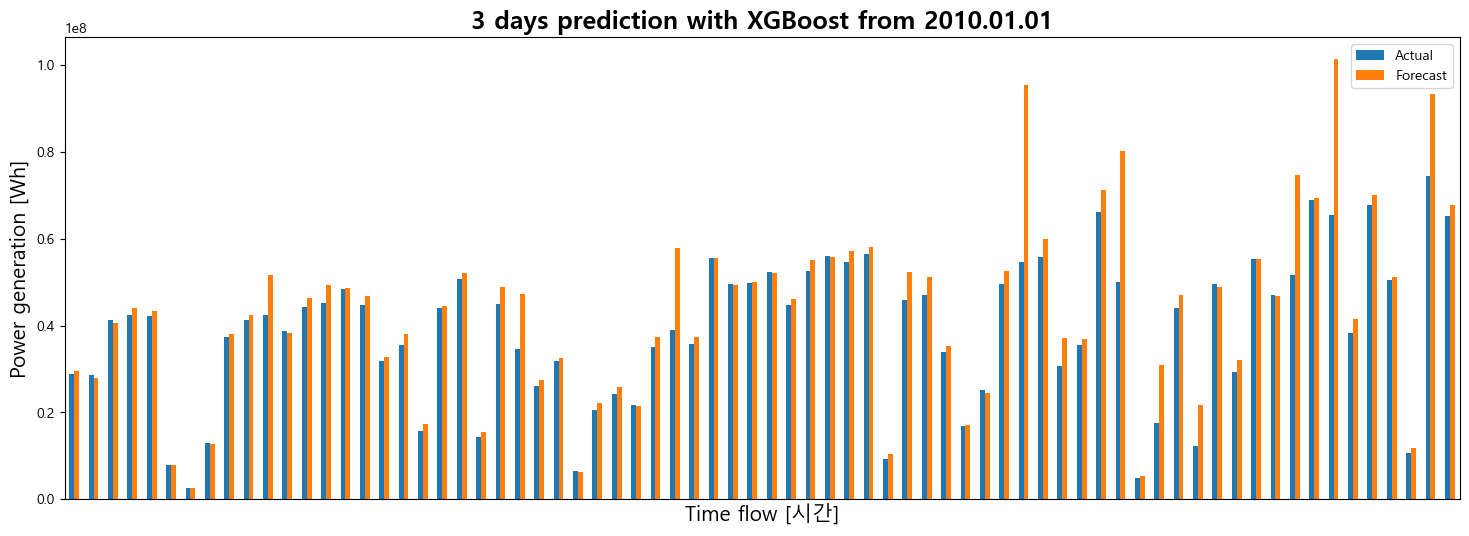

In [137]:
# XGBoost 예측 시각화
days = 3
show_df = pd.DataFrame({
    'hours': power_data_dic['강원'].iloc[:24*days,1],
    'Actual': power_data_dic['강원'].iloc[:24*days,2],
    'Forecast': xgb_model.predict(weather_data_dic['강원'].iloc[:24*days,2:].to_numpy())
})

show_df.plot(x='hours', y=['Actual','Forecast'], kind='bar', figsize=(6*days,6))
plt.title(f'{days} days prediction with XGBoost from 2010.01.01', fontsize=18, fontweight='bold')
plt.xlabel('Time flow [시간]', fontsize=15)
plt.ylabel('Power generation [Wh]', fontsize=15)
plt.xticks([])
plt.show()

**LightGBM 훈련기록**

- 1회차  
lgb_n_estimators_list = [100, 200, 300, 400, 500]  
lgb_learning_rate_list = [0.05, 0.1, 0.2]  
lgb_min_child_weight_list = [1, 2, 3]  
lgb_reg_alpha_list = [0.1, 1, 10, 100]  
*best_params: (500, 0.1, 1, 10)*  
*test set score: 0.797227502469869*  

- 2회차  
lgb_n_estimators_list = [400, 500, 600, 700, 800, 900, 1000]  
lgb_learning_rate_list = [0.05, 0.1, 0.2]  
lgb_min_child_weight_list = [1, 2, 3]  
lgb_reg_alpha_list = [0.1, 1, 10, 100]  
*best_params: (1000, 0.1, 1, 100)*  
*test set score: 0.7976530922936225*  

- 3회차  
lgb_n_estimators_list = [900, 1000, 1100, 1200, 1300]  
lgb_learning_rate_list = [0.05, 0.1]  
lgb_min_child_weight_list = [1, 2]  
lgb_reg_alpha_list = [1, 10, 100, 200]  
*best_params: (1300, 0.1, 1, 100)*  
*test set score: 0.7976794793961852*  

- 4회차  
lgb_n_estimators_list = [1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]  
lgb_learning_rate_list = [0.1]  
lgb_min_child_weight_list = [1]  
lgb_reg_alpha_list = [100]  
*best_params: (2000, 0.1, 1, 100)*  
*test set score: 0.7977009898768442*  

트리 개수를 늘릴수록 score가 올라가긴 하지만 그 정도가 크지 않아 훈련 종료

In [149]:
lgb_n_estimators_list = [1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
lgb_learning_rate_list = [0.1]
lgb_min_child_weight_list = [1]
lgb_reg_alpha_list = [100]
lgb_params_list = list(itertools.product(lgb_n_estimators_list, lgb_learning_rate_list, lgb_min_child_weight_list, lgb_reg_alpha_list))
lgb_score_list = []

for idx,coef in enumerate(lgb_params_list):
    # LightGBM 훈련
    lgb_model = LGBMRegressor(n_estimators=coef[0], learning_rate=coef[1], min_child_weight=coef[2], reg_alpha=coef[3], n_jobs=-1, verbose=0, random_state=42)
    lgb_model.fit(X_train, y_train)
    lgb_score_list.append(lgb_model.score(X_test, y_test))
    # 진행도 출력
    clear_output(wait=True)
    print(f'진행도: {(idx+1)/len(lgb_params_list)*100:.2f}%')

# 최적 파라미터 도출
lgb_best_params_idx = lgb_score_list.index(max(lgb_score_list))
lgb_best_params = lgb_params_list[lgb_best_params_idx]
print(f'best_params: {lgb_best_params}')
# 최적 파라미터로 score확인
lgb_model = LGBMRegressor(n_estimators=lgb_best_params[0], learning_rate=lgb_best_params[1], min_child_weight=lgb_best_params[2], reg_alpha=lgb_best_params[3], verbose=0, random_state=42)
lgb_model.fit(X_train, y_train)
print(f'test set score: {lgb_model.score(X_test, y_test)}')

진행도: 100.00%
best_params: (2000, 0.1, 1, 100)
test set score: 0.7977009898768442


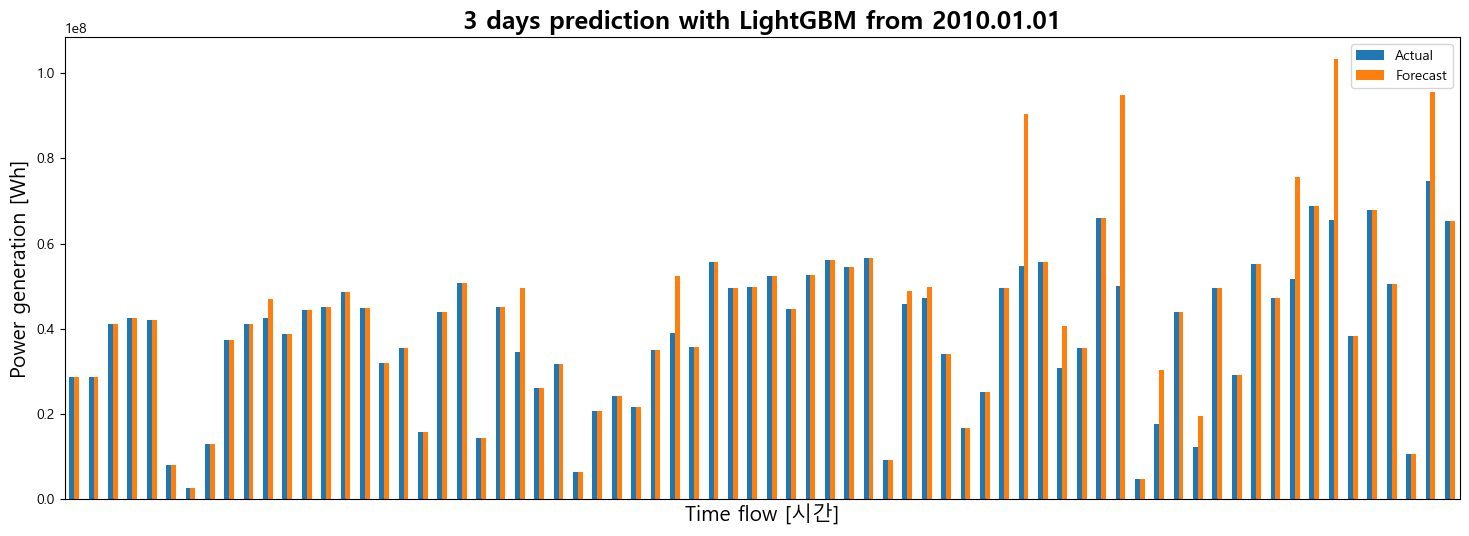

In [145]:
# LightGBM 예측 시각화
days = 3
show_df = pd.DataFrame({
    'hours': power_data_dic['강원'].iloc[:24*days,1],
    'Actual': power_data_dic['강원'].iloc[:24*days,2],
    'Forecast': lgb_model.predict(weather_data_dic['강원'].iloc[:24*days,2:].to_numpy())
})

show_df.plot(x='hours', y=['Actual','Forecast'], kind='bar', figsize=(6*days,6))
plt.title(f'{days} days prediction with LightGBM from 2010.01.01', fontsize=18, fontweight='bold')
plt.xlabel('Time flow [시간]', fontsize=15)
plt.ylabel('Power generation [Wh]', fontsize=15)
plt.xticks([])
plt.show()

Gradient Boosting, XGBoost, LightGBM 모두 best parameter를 적용한 모델의 test set에 대한 score가 0.79를 넘지 않았다.  
따라서 훈련 속도가 느린 Gradient Boosting을 제외하고, XGBoost와 LightGBM 중 '덜 틀리는'모델을 선택하기로 하여 XGBoost를 선택하였다.

In [256]:
local_name_list = ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']

for local in local_name_list:
    data = weather_data_dic[local].iloc[:,2:].to_numpy()
    target = power_data_dic[local].iloc[:,2].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    n_estimators_list = list(range(100, 1001, 50))
    learning_rate_list = [0.05, 0.1, 0.2, 0.3]
    min_child_weight_list = [1, 2, 3]
    reg_alpha_list = [0.1, 1, 10, 100, 200]
    params_list = list(itertools.product(n_estimators_list, learning_rate_list, min_child_weight_list, reg_alpha_list))
    score_list = []

    for idx,coef in enumerate(params_list):
        # XGBoost 훈련
        model = XGBRegressor(n_estimators=coef[0], learning_rate=coef[1], min_child_weight=coef[2], reg_alpha=coef[3], n_jobs=-1, random_state=42)
        model.fit(X_train, y_train)
        score_list.append(model.score(X_test, y_test))
        # 진행도 출력
        clear_output(wait=True)
        print(f'{local} 진행도: {(idx+1)/len(params_list)*100:.2f}%')
    
    # 최적 파라미터 도출
    best_params_idx = score_list.index(max(score_list))
    best_params = params_list[best_params_idx]
    # 최적 파라미터로 모델 저장
    model = XGBRegressor(n_estimators=best_params[0], learning_rate=best_params[1], min_child_weight=best_params[2], reg_alpha=best_params[3], random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, f'model_files/{local}_model_{best_params}.pkl')
print('All Completed')

충북 진행도: 100.00%
All Completed


In [16]:
# 최적 파라미터로 훈련이 끝난 모델들의 score확인
file_name_list = os.listdir('model_files')[-17:]
best_score_list = []

for file_name in file_name_list:
    data = weather_data_dic[file_name[0:2]].iloc[:,2:].to_numpy()
    target = power_data_dic[file_name[0:2]].iloc[:,2].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    model = joblib.load('model_files/'+file_name)
    best_score_list.append(file_name[0:2]+': '+model.score(X_test, y_test).astype(str))

for score in best_score_list:
    print(score)

강원: 0.7984781668486881
경기: 0.8161155507577827
경남: 0.7790783668423481
경북: 0.8811838878680678
광주: 0.9474773482329877
대구: 0.8726352420555379
대전: 0.9301825741997292
부산: 0.9014376162677604
서울: 0.9507380241176532
세종: 0.7800341851767675
울산: 0.7583480145373765
인천: 0.7617614297943636
전남: 0.5553605257605201
전북: 0.5838691137608202
제주: 0.9083772617630619
충남: 0.858457393204718
충북: 0.9353544784859595


## 최종 선택
전남과 전북의 $R^2$ 값이 낮게 나온 이유는 2023년에 시설 확장이 크게 일어나면서 발전량 데이터가 급격하게 증가했기 때문  
기상 데이터는 비교적 일정한 패턴을 보이는 반면, 발전량 데이터는 시설 확장으로 인한 급격한 증가로 인해 제대로된 훈련이 어려워짐  
이에 따라 한 해의 데이터만을 사용하여 모델을 훈련하기로 결정  
또한 전남의 2022년 발전량 데이터 중 이상치를 수정

In [112]:
power_data_dic['전남'].iloc[807,2] = power_data_dic['전남'].iloc[807,2]/100000
power_data_dic['전남'].iloc[822,2] = power_data_dic['전남'].iloc[822,2]/100
local_name_list = ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']

for local in local_name_list:
    data = weather_data_dic[local].iloc[731:1096,2:].to_numpy()
    target = power_data_dic[local].iloc[731:1096,2].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    n_estimators_list = list(range(100, 1001, 50))
    learning_rate_list = [0.05, 0.1, 0.2, 0.3]
    min_child_weight_list = [1, 2, 3]
    reg_alpha_list = [0.1, 1, 10, 100, 200]
    params_list = list(itertools.product(n_estimators_list, learning_rate_list, min_child_weight_list, reg_alpha_list))
    score_list = []

    for idx,coef in enumerate(params_list):
        # XGBoost 훈련
        model = XGBRegressor(n_estimators=coef[0], learning_rate=coef[1], min_child_weight=coef[2], reg_alpha=coef[3], n_jobs=-1, random_state=42)
        model.fit(X_train, y_train)
        score_list.append(model.score(X_test, y_test))
        # 진행도 출력
        clear_output(wait=True)
        print(f'{local} 진행도: {(idx+1)/len(params_list)*100:.2f}%')
    
    # 최적 파라미터 도출
    best_params_idx = score_list.index(max(score_list))
    best_params = params_list[best_params_idx]
    # 최적 파라미터로 모델 저장
    model = XGBRegressor(n_estimators=best_params[0], learning_rate=best_params[1], min_child_weight=best_params[2], reg_alpha=best_params[3], random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, f'model_files/{local}_model_{best_params[0]},{best_params[1]},{best_params[2]},{best_params[3]}.pkl')
print('All Completed')

충북 진행도: 100.00%
All Completed


In [168]:
# 최적 파라미터로 훈련이 끝난 모델들의 score확인
file_name_list = os.listdir('model_files')[-17:]
best_score_list = []

for file_name in file_name_list:
    data = weather_data_dic[file_name[0:2]].iloc[731:1096,2:].to_numpy()
    target = power_data_dic[file_name[0:2]].iloc[731:1096,2].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    model = joblib.load('model_files/'+file_name)
    best_score_list.append(file_name[0:2]+': '+model.score(X_test, y_test).astype(str))

for score in best_score_list:
    print(score)

강원: 0.9439896577255904
경기: 0.9742621705171118
경남: 0.9667534015219768
경북: 0.9513200597034245
광주: 0.9382193951745111
대구: 0.9648250625853937
대전: 0.9562823297812114
부산: 0.9561806655498535
서울: 0.9630009639197201
세종: 0.8442100665074554
울산: 0.8322047936267182
인천: 0.8936052893189881
전남: 0.9454518026099584
전북: 0.9277140732631931
제주: 0.9220537503839368
충남: 0.962868160656473
충북: 0.9523480082142146


In [86]:
# 누적설비용량과 신규설비용량 데이터 준비
cum_fac_dic = {
    2023: [48.87, 200.01, 162.71, 119.1, 269.81, 47.31, 106.13, 70.74, 1471.28, 1719.64, 1328.4, 2826.42, 4167.25, 5255.4, 3197, 1583.19, 547.87]
}
new_fac_dic = {
    2023: [2.02, 32.06, 33.39, 15.31, 30.17, 4.76, 23.21, 7.64, 213.26, 148.06, 168.97, 273.57, 309.53, 842.02, 448.14, 180.75, 23.42],
    2022: [4.05, 31.74, 22.81, 13.87, 24.87, 4.04, 12.35, 7.5, 181.16, 203.65, 174.91, 276.57, 637.82, 658.01, 486.68, 217.81, 37.86],
    2021: [3.44, 26.38, 25.1, 9.69, 34.53, 7.45, 17.76, 7.15, 222.55, 302.67, 219.72, 484.59, 798.45, 856.62, 678.42, 262.62, 123.61],
    2020: [4.54, 20.5, 13.97, 17.11, 28.86, 3.46, 16.23, 11.81, 231.18, 320.72, 239.89, 522.41, 746.06, 1118.01, 466.16, 255.63, 104.26],
    2019: [7.01, 14.56, 22.08, 13.69, 44.75, 7.25, 7.24, 9.19, 230.88, 234.99, 205.36, 506.07, 555.13, 503.92, 393.46, 225.89, 92.61]
}
for year in list(new_fac_dic.keys())[1:]:
    cum_fac_dic[year] = []
    
    for idx in range(17):
        cum_fac_dic[year].append(round(cum_fac_dic[year+1][idx]-new_fac_dic[year+1][idx], 2))

In [87]:
# 도시별 설비 증감율 계산
inc_ratio_dic = {}

for year in list(cum_fac_dic.keys())[:-1]:
    inc_ratio_dic[year] = []
    for idx in range(17):
        inc_ratio_dic[year].append(round((cum_fac_dic[year][idx]-cum_fac_dic[year-1][idx])/cum_fac_dic[year-1][idx], 3))

In [88]:
# 도시별 설비 증감율의 평균 계산
ratio_mean_list = []

for idx in range(17):
    result = 0
    for year in inc_ratio_dic.keys():
        result += inc_ratio_dic[year][idx]
    ratio_mean_list.append(round(result/len(inc_ratio_dic), 2))

In [89]:
# 데이터의 순서 재정렬
local_name_list = ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']
tmp_local_name_list = ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주']
sorted_ratio_mean_list = [np.nan]*17

for idx,local in enumerate(local_name_list):
    sorted_ratio_mean_list[idx] = ratio_mean_list[tmp_local_name_list.index(local)]
print(sorted_ratio_mean_list)

[0.24, 0.24, 0.25, 0.31, 0.16, 0.25, 0.15, 0.22, 0.09, 0.18, 0.31, 0.17, 0.32, 0.26, 0.22, 0.23, 0.27]


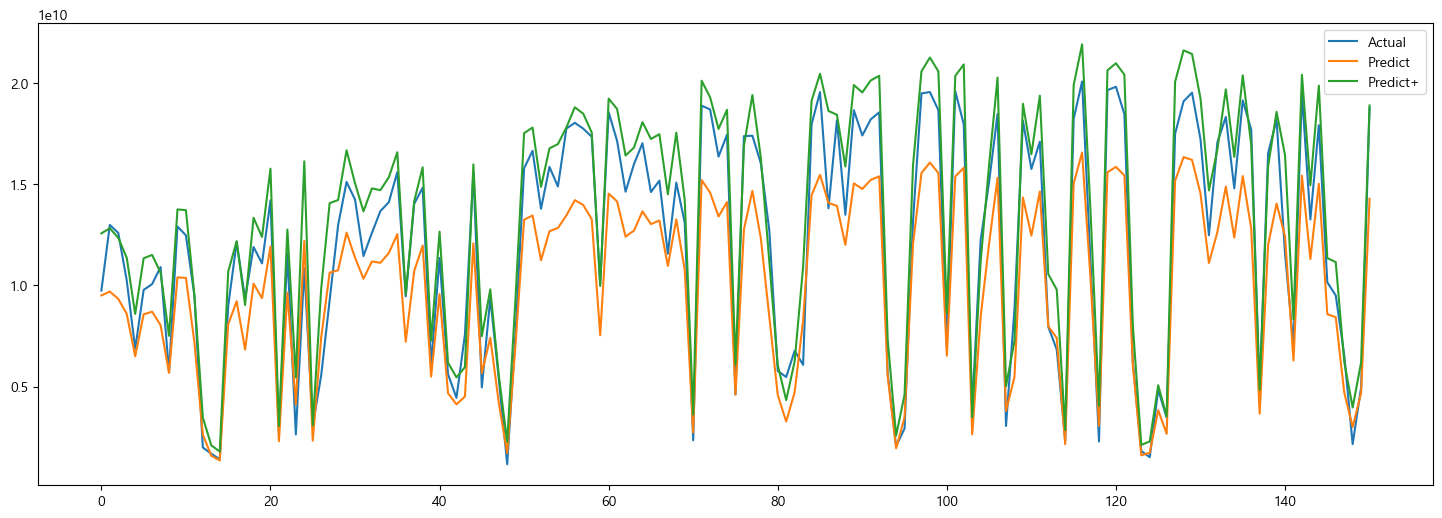

In [80]:
name = '전남'
dir = local_name_list.index(name)
data = weather_data_dic[name].iloc[1096:1247,2:].to_numpy()

test_model = joblib.load(f'model_files/{name}_model_(200, 0.05, 2, 0.1).pkl')
test_result = test_model.predict(data)

plt.figure(figsize=(18, 6))
plt.plot(power_data_dic[name].iloc[1096:1247,2].to_numpy(), label='Actual')
plt.plot(test_result, label='Predict')
plt.plot(test_result * (1+sorted_ratio_mean_list[dir]), label='Predict+')
plt.legend()
plt.show()

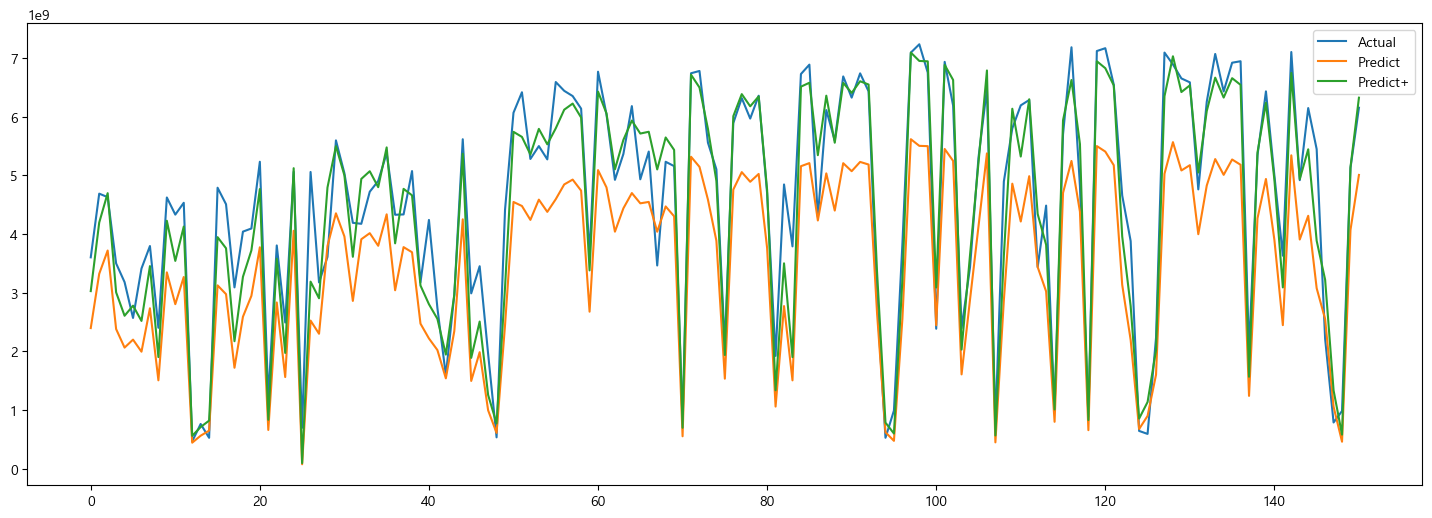

In [290]:
name = '전북'
dir = local_name_list.index(name)
data = weather_data_dic[name].iloc[1096:1247,2:].to_numpy()

test_model = joblib.load(f'model_files/{name}_model_(100, 0.3, 3, 100).pkl')
test_result = test_model.predict(data)

plt.figure(figsize=(18, 6))
plt.plot(power_data_dic[name].iloc[1096:1247,2].to_numpy(), label='Actual')
plt.plot(test_result, label='Predict')
plt.plot(test_result * (1+sorted_ratio_mean_list[dir]), label='Predict+')
plt.legend()
plt.show()